# Model Insights and Conclusions

This is notebook 5 (out of 5) for <b>Project 3</b> of the GA Data Science Immersive<br>
Notebook by: <b>Martijn de Vries</b><br>
martijndevries91@gmail.com

## Problem Statement

A US political consultancy company is researching how news sources and discussed topics differ between the US political mainstream and the conservative right-wing media. In the last decade or so, the US political right-wing has been increasingly described as living in an entirely separate information ecosystem from the political mainstream. In order to gauge how intense this effect is, we will collect, process, and classify the Reddit content of two politically-themed subreddit that reflect the mainstream and conservative voters respectively: <b>r/politics</b> and <b>r/conservative</b>. 

For this project, we will build two separate branches of models: one for post submissions (largely consisting of links to news sites), and another for comments (consisting of actual Reddit users discussing political news). As this is a binary classification problem where the two classes are of equal interest and will be approximately balanced, we will use the accuracy score as the main metric to gauge the success of the classification model. 

Because political news is always evolving, we have chosen a specific moment in time: the month leading up to the 2022 midterms, October 6th to November 6th 2022. This ensures that 1) the same news cycle is covered for both subreddits, 2) both subreddits were at peak activity, and 3) maximum potential for interesting insights in the way that news is discussed within these two subreddits.

## In this Notebook

I will load in the best models from the modeling notebook that I pickled. I will do some interpretation regarding which features are the most predictive, and look at the final accuracy score vs the baseline. For the comments model, I will do some additional analysis to try and see why comments get misclassified. At the end, I give a summary and conclusions for the entire project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import re

#custom
from custom_funcs import Tfidf_BigramReducer, my_preprocessor

#sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


## 1) Posts model: insights

Let's start by re-loading the data, and the stacked model that I pickled in the modeling notebook. 

Sidenote: I put the custom transformer class Tfidf_BigramReducer and the my_preprocessor function in a .py file so that I can just import them (see imports above) without having to copy-paste them here.

In [2]:
post_df = pd.read_csv('../data/all_submissions_cleaned.csv')

post_df['subreddit'] = post_df['subreddit'].map({'conservative':0, 'politics':1})

X = post_df[['title', 'num_comments', 'domain']]
y = post_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
with open('../pickled_models/stacked_model_submissions.pkl', 'rb') as pickle_in:
    stacked_model_subs = pickle.load(pickle_in)

In [4]:
stacked_model_subs

StackingClassifier(estimators=[('m1',
                                Pipeline(steps=[('ct',
                                                 ColumnTransformer(transformers=[('tfbg',
                                                                                  Tfidf_BigramReducer(bf=0.1,
                                                                                                      max_features=30000,
                                                                                                      preprocessor=<function my_preprocessor at 0x7fd9a3e7e280>,
                                                                                                      stop_words='english'),
                                                                                  'title'),
                                                                                 ('ss',
                                                                                  StandardScaler(),
                                                                                  ['num_comments']),
                                                                                 ('ohe',
                                                                                  OneHotEncoder(drop='first',
                                                                                                sparse_output=False),
                                                                                  ['domain'])])),
                                                ('lr',
                                                 Lo...
                                Pipeline(steps=[('ct',
                                                 ColumnTransformer(transformers=[('tfbg',
                                                                                  Tfidf_BigramReducer(bf=0.1,
                                                                                                      max_features=40000,
                                                                                                      preprocessor=<function my_preprocessor at 0x7fd9a3e7e280>,
                                                                                                      stop_words='english'),
                                                                                  'title'),
                                                                                 ('mm',
                                                                                  MinMaxScaler(),
                                                                                  ['num_comments']),
                                                                                 ('ohe',
                                                                                  OneHotEncoder(drop='first',
                                                                                                sparse_output=False),
                                                                                  ['domain'])])),
                                                ('nb', MultinomialNB())]))],
                   final_estimator=LogisticRegression())

Although the stacked model in itself may not be that interpretable, the individual models that make up our StackingClassifier all have some degree of interpretability:
1) for Logistic Regression, each feature has coefficients that return the log odds of a certain feature changing the odds towards or away from class 1
2) Random Forest returns a list of feature importances
3) Multinomial NB returns a list of log probabilities for each class, that that feature is part of an entry of that class <br>

Which of the models was weighed the most by the final estimator?

In [5]:
models = ['Logistic Regression', 'Random Forest', 'Naive Bayes']
final_coefs = stacked_model_subs.final_estimator_.coef_[0]
for i in range(3):
    print(f'{models[i]} weight: {round(final_coefs[i],3)}')

Logistic Regression weight: 0.746
Random Forest weight: 5.662
Naive Bayes weight: 1.94


### 1.1) Random Forest interpretation

Above, we can see that the model that is weighted the most in the stacked model is the Random Forest classifier. For that specific model, we can get a list of feature importances to figure out which features the model thought were the most important. In order to access the attributes of the Random Forest Classifier, we need to call the named_estimators_ attribute of the stacked model and select model 2. As each base model is a Pipeline object in itself, we then need to access the random forest with the named_steps attribute and use the alias we specified for the random forest (rf).

In [6]:
rf_in_stack = stacked_model_subs.named_estimators_.m2.named_steps.rf
rf_importances = rf_in_stack.feature_importances_
ct2_in_stack = stacked_model_subs.named_estimators_.m2.named_steps.ct
rf_feature_names = ct2_in_stack.get_feature_names_out()

In [7]:
zipped_f = zip(rf_feature_names, rf_importances)
sorted_f = sorted(zipped_f, key= lambda x: x[1], reverse=True)[:500]

hi_mono_names, hi_bi_names = [], []
hi_mono_imp, hi_bi_imp = [], []

for feature in sorted_f:
    if 'tfbg' in feature[0]:
        if len(feature[0].split(' ')) == 1:
            hi_mono_names.append(feature[0][6:])
            hi_mono_imp.append(feature[1])
        if len(feature[0].split(' ')) == 2:
            hi_bi_names.append(feature[0][6:])
            hi_bi_imp.append(feature[1])

According to the random forest classifier, The additional features 'domain' and num_comments' help the most with classification:

In [8]:
sorted_f[:20]

[('ss__num_comments', 0.13504547947870602),
 ('ohe__domain_reddit', 0.021788010391990447),
 ('ohe__domain_image', 0.01865944191020541),
 ('tfbg__trump', 0.01256331212122673),
 ('ohe__domain_breitbart', 0.011811011210621633),
 ('ohe__domain_foxnews', 0.010183111754516814),
 ('ohe__domain_tampafp', 0.009680137580473275),
 ('ohe__domain_none', 0.00958368723814532),
 ('ohe__domain_nypost', 0.009103336976758216),
 ('ohe__domain_washingtonpost', 0.008131078008063192),
 ('ohe__domain_cnn', 0.007861549479325752),
 ('ohe__domain_thehill', 0.0074885574957576),
 ('ohe__domain_nytimes', 0.007053461086324851),
 ('ohe__domain_redstate', 0.0070488011878285005),
 ('ohe__domain_other', 0.006803747182445233),
 ('ohe__domain_politico', 0.005494617110135774),
 ('tfbg__biden', 0.0045070407840302334),
 ('ohe__domain_huffpost', 0.0042669915513446335),
 ('ohe__domain_youtube', 0.004218938333132806),
 ('ohe__domain_theguardian', 0.004169192498097183)]

One thing that is not directly obvious from these feature importances is the <i>direction</i>. In other words, does the word 'trump' being mentioned more often imply that the post is more likely to come from r/politics, or from r/conservative?
One way to figure out the direction would be to simply calculate the pearson r coefficient between the feature and the subreddit. I got that idea from stackoverflow, here:
https://stackoverflow.com/questions/58314707/how-to-distinguish-the-direction-of-important-features-from-xgboost-or-random-fo

In [9]:
def calc_pearson_r_feature(feature_list, X_trans, y_train):
    """
    Calculates the pearson r correlation coef from all tfbg columns passed in feature_list and the y data, given the X and y data passed to the classifier 
    """
    dir_list = [] #list with feature direction
    for feature in feature_list:
        ind = np.where('tfbg__' + feature == rf_feature_names)[0][0]
        yl = y_train.shape[0]
        X_col = X_trans[:,ind].todense().reshape(yl)
        p_r = np.corrcoef(X_col, y_train)[0,1]
        if p_r <= 0: 
            #A negative coefficient means more towards zero (= r/conservative)
            dir_list.append(0)
        elif p_r > 0:
            dir_list.append(1)
    return dir_list

In [10]:
#transform the training data again to access tfidf columns
X_tr = ct2_in_stack.fit_transform(X_train)
dir_list_mono = calc_pearson_r_feature(hi_mono_names, X_tr, y_train)
dir_list_bi = calc_pearson_r_feature(hi_bi_names, X_tr, y_train)

Now let's make a barplot of the monograms and bigrams with the most relative importance. I'll color-code each entry red or blue, depending on whether the occurence of the feature means the post is more likely to be from r/conservative or from r/politics, respectively.

In [11]:
def make_barplot(ax, wl, values, labels, directions):
    """
    Make a horizontal barplot for the most important random forest features, colorcoding them by direction
    """
    yl = np.arange(wl)
    clr = ['tab:red' if x <= 0 else 'tab:blue' for x in directions[:wl]]
    ax.barh(yl, values[:wl], color=clr)
    ax.set_yticks(yl)
    ax.set_yticklabels(labels=labels[:wl], fontsize=12)
    ax.invert_yaxis()
    ax.set_xlabel('Relative weight', fontsize=12)
    
    return

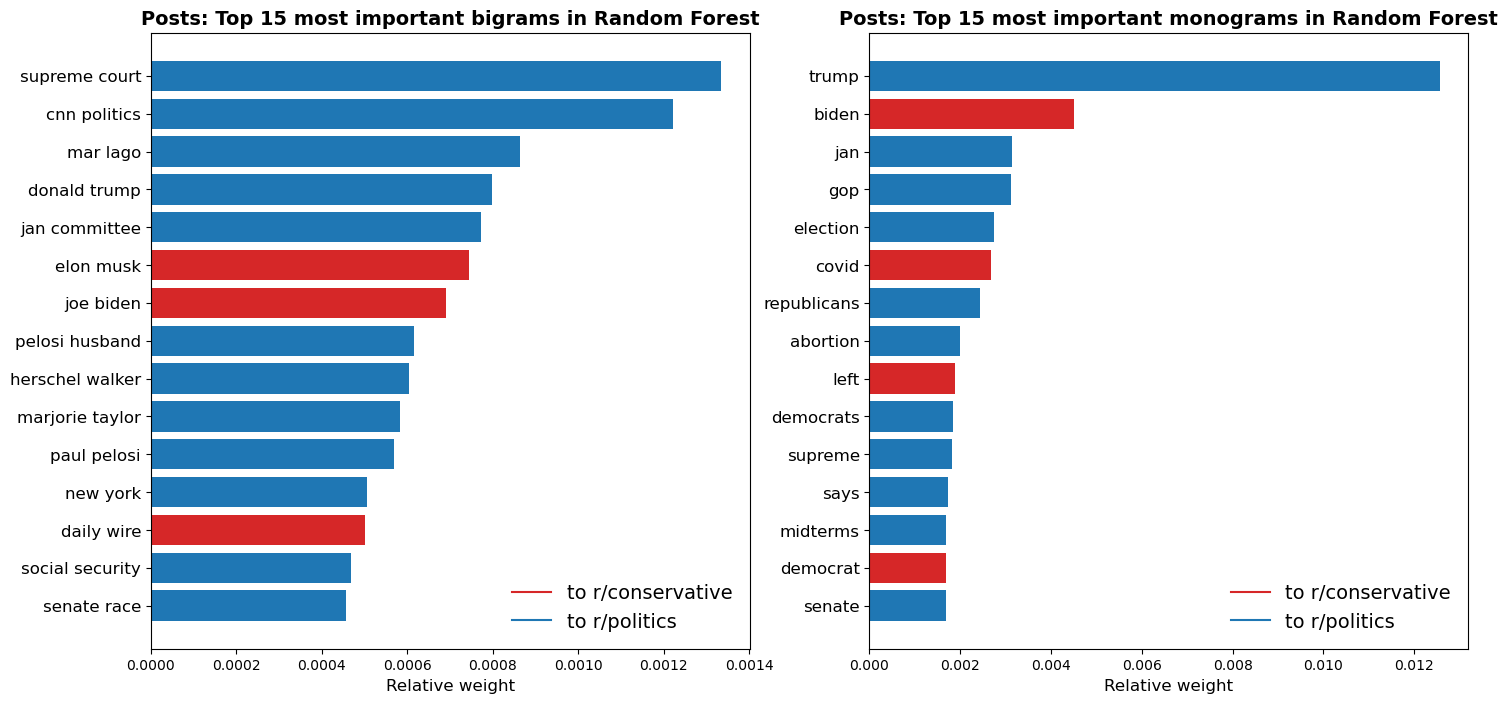

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8))

make_barplot(ax2, 15, hi_mono_imp, hi_mono_names, dir_list_mono)
make_barplot(ax1, 15, hi_bi_imp, hi_bi_names, dir_list_bi)

ax1.set_title('Posts: Top 15 most important bigrams in Random Forest', fontweight='bold', fontsize=14)
ax2.set_title('Posts: Top 15 most important monograms in Random Forest', fontweight='bold', fontsize=14)

#dummy legend (because barplot is a single command
#(see https://stackoverflow.com/questions/17209403/arbitrary-key-or-legend-with-matplotlib)
labels = ['to r/conservative', 'to r/politics']
colors=['tab:red', 'tab:blue']
dummies = [ax1.plot([], [], ls='-', c=c)[0] for c in colors]        
ax1.legend(dummies, labels, frameon=False, numpoints=1, fontsize=14, loc='lower right')
ax2.legend(dummies, labels, frameon=False, numpoints=1, fontsize=14, loc='lower right')


fig.savefig('../figures/sub_rf_features.png', dpi=300)

plt.show()

### 1.2) Logistic Regression Interpretation

Let's look at the coefficients of the logistic regression model. We can access the attributes we want in a similar manner as for the random forest

In [13]:
lr_in_stack = stacked_model_subs.named_estimators_.m1.named_steps.lr
lr_coefs = lr_in_stack.coef_[0]
ct1_in_stack = stacked_model_subs.named_estimators_.m1.named_steps.ct
lr_feature_names = ct1_in_stack.get_feature_names_out()

Now let's do a similar thing as for the random forest classifier - we sort the coefficients (by absolute value, we care about high values both positive and negative), and then get the most important tfbg related columns.

In [14]:
zipped_lr = zip(lr_feature_names, lr_coefs)
sorted_lr = sorted(zipped_lr, key= lambda x: np.abs(x[1]), reverse=True)[:500]

In [15]:
sorted_lr[:20]

[('ohe__domain_image', -4.135640636674763),
 ('ohe__domain_tampafp', -3.7595375368243533),
 ('ohe__domain_redstate', -3.54714835231733),
 ('ohe__domain_breitbart', -3.4226139814947807),
 ('ohe__domain_hotair', -3.2138321994833077),
 ('tfbg__trump', 3.062362714528558),
 ('ohe__domain_thefederalist', -3.0159722594571),
 ('ohe__domain_amgreatness', -2.998875507629035),
 ('ohe__domain_theblaze', -2.9873233155942103),
 ('ohe__domain_nytimes', 2.932081693632392),
 ('ohe__domain_pjmedia', -2.892851189389558),
 ('ohe__domain_notthebee', -2.8558322872659962),
 ('ohe__domain_newsmax', -2.851534625342928),
 ('ohe__domain_huffpost', 2.8105740424528722),
 ('ohe__domain_townhall', -2.770039825255719),
 ('ohe__domain_reddit', -2.68927616883416),
 ('ohe__domain_timcast', -2.6861071231818205),
 ('ohe__domain_babylonbee', -2.6645746717925625),
 ('ohe__domain_commondreams', 2.6104210128068672),
 ('ohe__domain_justthenews', -2.56551620931431)]

Again, it's clear the domain features carried a lot of predictive power!

In [16]:
hi_mono_names, hi_bi_names = [], []
hi_mono_imp, hi_bi_imp = [], []

for feature in sorted_lr:
    if 'tfbg' in feature[0]:
        if len(feature[0].split(' ')) == 1:
            hi_mono_names.append(feature[0][6:])
            hi_mono_imp.append(feature[1])
        if len(feature[0].split(' ')) == 2:
            hi_bi_names.append(feature[0][6:])
            hi_bi_imp.append(feature[1])

We can again make a barplot of the most important monograms and bigrams. It is important to keep in mind that these coefficients measure something 

In [17]:
def make_barplot_lr(ax, wl, values, labels):
    """
    Make a horizontal barplot for the largest logarithmic regression coefficients
    """
    yl = np.arange(wl)
    clr = ['tab:red' if x <= 0 else 'tab:blue' for x in values[:wl]]
    ax.barh(yl, values[:wl], color=clr)
    ax.set_yticks(yl)
    ax.set_yticklabels(labels=labels[:wl], fontsize=12)
    ax.invert_yaxis()
    ax.set_xlabel('Log odds coefficient', fontsize=12)
    
    return

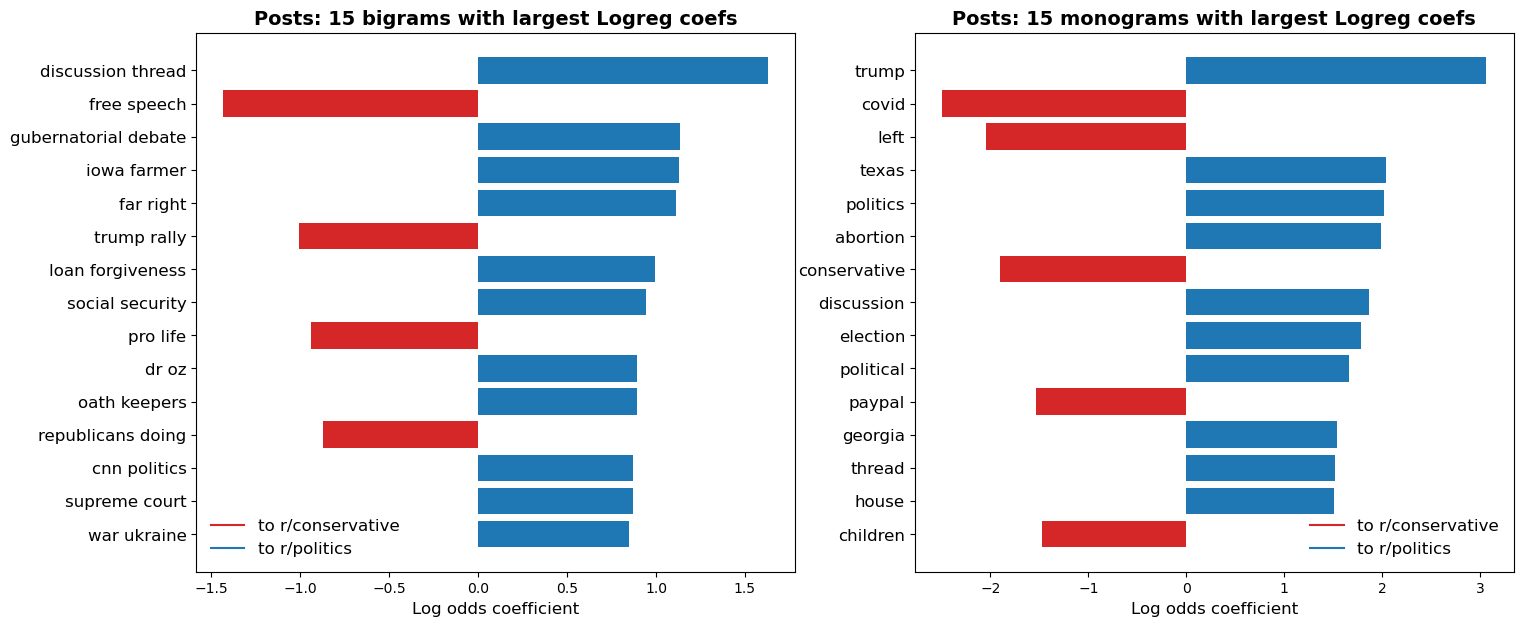

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))

make_barplot_lr(ax2, 15, hi_mono_imp, hi_mono_names)
make_barplot_lr(ax1, 15, hi_bi_imp, hi_bi_names)

ax1.set_title('Posts: 15 bigrams with largest Logreg coefs', fontweight='bold', fontsize=14)
ax2.set_title('Posts: 15 monograms with largest Logreg coefs', fontweight='bold', fontsize=14)

#dummy legend (because barplot is a single command:
labels = ['to r/conservative', 'to r/politics']
colors=['tab:red', 'tab:blue']
dummies = [ax1.plot([], [], ls='-', c=c)[0] for c in colors]        
ax1.legend(dummies, labels, frameon=False, numpoints=1, fontsize=12, loc='lower left')
ax2.legend(dummies, labels, frameon=False, numpoints=1, fontsize=12, loc='lower right')


fig.savefig('../figures/sub_lr_features.png', dpi=300)

plt.show()

The usage of TfidfVectorizer rather than the more simple CountVectorizer does make the interpretation more difficult here. If it were CountVectorizer, we could simply say that one occurence of the word of the n-gram would increase or decrease the odds according to the measured coefficient. But with TfidfVectorizer, the words are weighted by the inverse document frequency. And so what 'an occurence' means becomes a more abstract, normalized thing. Still, these plots do give us some impression of how certain words will swing the odds towards or away from either of the subreddit.

### 1.3) Naive Bayes interpretation

For this algorithm, each feature includes conditional probabilities for each class that the feature is in a given entry of that class. I will divide the e-power of both, to give the relative probability of a given feature being in one class vs the other

In [19]:
nb_in_stack = stacked_model_subs.named_estimators_.m3.named_steps.nb
nb_logprobs = nb_in_stack.feature_log_prob_
nb_relprobs = np.exp(nb_logprobs[1])/np.exp(nb_logprobs[0])
ct3_in_stack = stacked_model_subs.named_estimators_.m3.named_steps.ct
nb_feature_names = ct3_in_stack.get_feature_names_out()

In [20]:
zipped_nbf = zip(nb_feature_names, nb_relprobs)
sorted_nbf = sorted(zipped_nbf, key= lambda x: x[1], reverse=True)

In [21]:
sorted_nbf[:20]

[('ohe__domain_huffpost', 59.402440746856385),
 ('ohe__domain_newrepublic', 48.98095991407456),
 ('ohe__domain_lgbtqnation', 44.81236758096182),
 ('ohe__domain_edition', 42.72807141440548),
 ('ohe__domain_salon', 39.60162716457093),
 ('ohe__domain_commondreams', 39.60162716457092),
 ('ohe__domain_nytimes', 38.142619847981514),
 ('ohe__domain_thedailybeast', 26.7484674708067),
 ('ohe__domain_rollingstone', 24.490479957037277),
 ('ohe__domain_axios', 22.145646769661372),
 ('ohe__domain_independent', 21.885109748841835),
 ('ohe__domain_truthout', 21.88510974884182),
 ('ohe__domain_cnn', 21.506146809467943),
 ('ohe__domain_nbcnews', 18.609787201396117),
 ('ohe__domain_washingtonpost', 18.117343601605334),
 ('ohe__domain_latimes', 17.195443374089997),
 ('ohe__domain_msnbc', 16.67436933245092),
 ('ohe__domain_theatlantic', 14.2426904714685),
 ('ohe__domain_npr', 13.69680338022754),
 ('ohe__domain_theguardian', 13.339495465960736)]

It's no surprise that the 'domain' features weigh very heavily in this model as well.

Now let's make a final bar chart showing the largest relative probabilities for monograms and bigrams:

In [22]:
def add_features(feature, name_mono, imp_mono, name_bi, imp_bi, inv=False):
    """
    Adds feature name and feature importance to a set of lists, independently for monograms and bigrams
    """
    if 'tfbg' in feature[0]: 
        if len(feature[0].split(' ')) == 1:
            name_mono.append(feature[0][6:])
            imp_mono.append(feature[1])
        if len(feature[0].split(' ')) == 2:
            name_bi.append(feature[0][6:])
            imp_bi.append(feature[1])
    return

In [23]:
hi_mono_names_p, hi_bi_names_p = [], []
hi_mono_imp_p, hi_bi_imp_p = [], []

hi_mono_names_c, hi_bi_names_c = [], []
hi_mono_imp_c, hi_bi_imp_c = [], []

for i in range(200):
    feature_p = sorted_nbf[i]
    feature_c = sorted_nbf[-(i+1)]
    
    add_features(feature_p, hi_mono_names_p, hi_mono_imp_p,  hi_bi_names_p, hi_bi_imp_p)
    add_features(feature_c, hi_mono_names_c, hi_mono_imp_c,  hi_bi_names_c, hi_bi_imp_c, inv=True)


In [24]:
def make_barplot_nb(ax, wl, val_c, val_p, label_c, label_p):
    """
    Make a horizontal barplot for the largest Naive Bayes relative odds
    """
    yl = np.arange(wl*2)
    clr = ['tab:red'] * wl + ['tab:blue'] * wl

    val_c = [1/x for x in val_c]
    ax.barh(yl, val_c[:wl] + val_p[:wl], color=clr)
    ax.set_yticks(yl)
    ax.set_yticklabels(labels=label_c[:wl] + label_p[:wl], fontsize=16)
    ax.invert_yaxis()
    ax.set_xlabel('Relative odds', fontsize=16)
    return

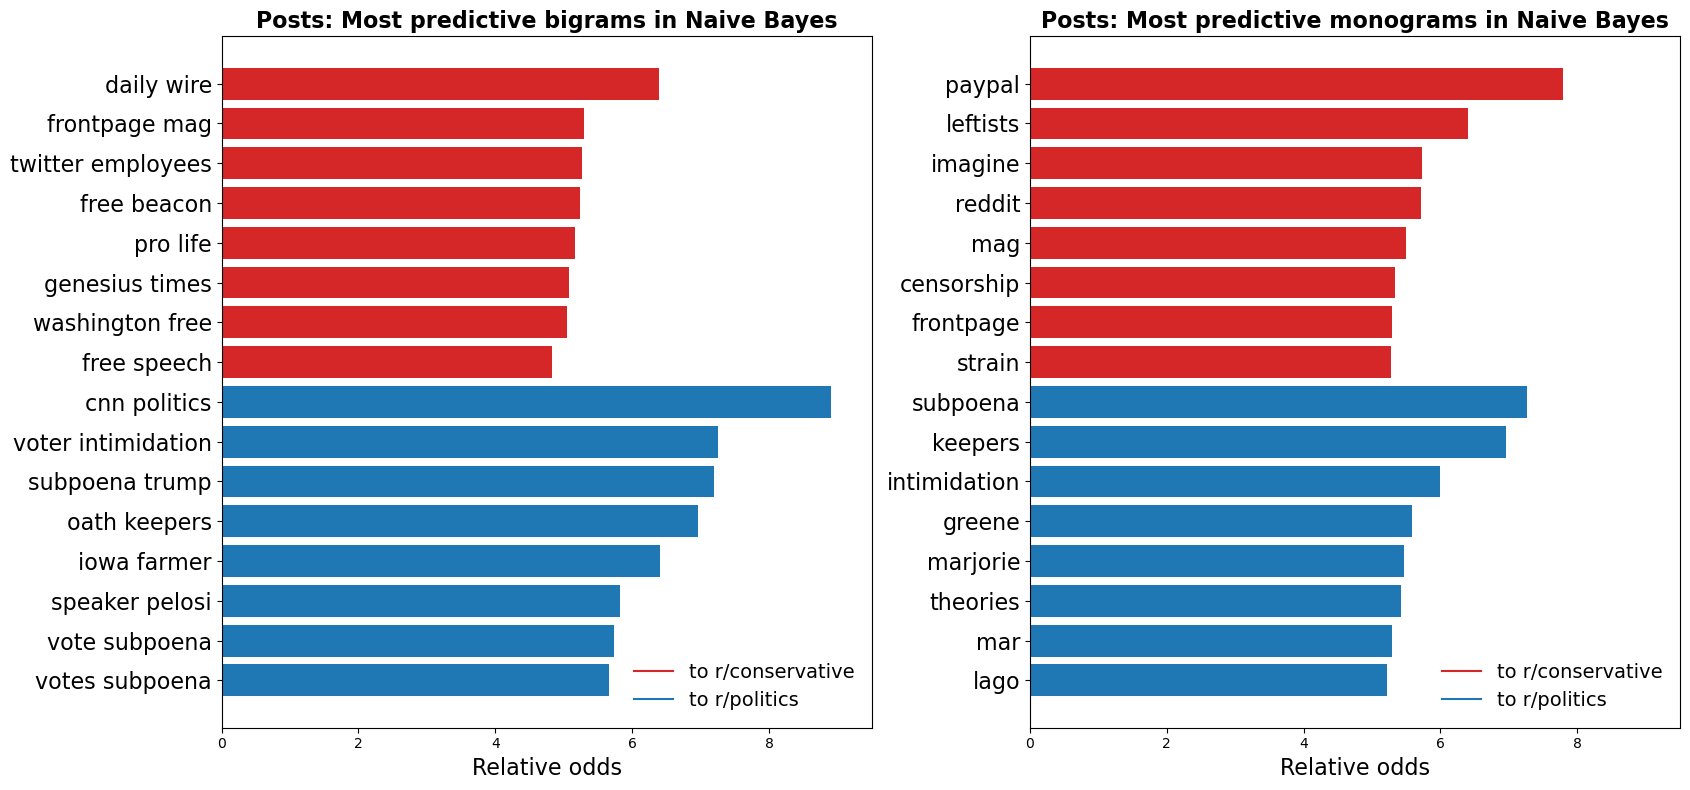

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8))

make_barplot_nb(ax2, 8, hi_mono_imp_c, hi_mono_imp_p, hi_mono_names_c, hi_mono_names_p)
make_barplot_nb(ax1, 8, hi_bi_imp_c, hi_bi_imp_p, hi_bi_names_c, hi_bi_names_p)

ax1.set_title('Posts: Most predictive bigrams in Naive Bayes', fontweight='bold', fontsize=16)
ax2.set_title('Posts: Most predictive monograms in Naive Bayes', fontweight='bold', fontsize=16)
ax1.set_xlim(0, 9.5)
ax2.set_xlim(0, 9.5)

#dummy legend (because barplot is a single command:
labels = ['to r/conservative', 'to r/politics']
colors=['tab:red', 'tab:blue']
dummies = [ax1.plot([], [], ls='-', c=c)[0] for c in colors]        
ax1.legend(dummies, labels, frameon=False, numpoints=1, fontsize=14, loc='lower right')
ax2.legend(dummies, labels, frameon=False, numpoints=1, fontsize=14, loc='lower right')


fig.tight_layout()
fig.savefig('../figures/sub_nb_features.png', dpi=300)

    
plt.show()

### 1.4) Title model insights: Summary

In the cells above, I've gone over the 3 different individual models that make up the stacking classifier, and tried make some visualizations that can help us interpret the importance of certain features. 

For each of the base models, it is clear that he 'domain' features add a lot of predictive power to the model. The 'domain' features specify which website the link comes from (provided it's a link, which it very often is). This makes a lot of sense on an intuitive level, as the mainstream media and conservative media are often very different. The fact that domain names are so predictive reinforces the idea that the two media universes do not mix a lot at all.

The feature importances, coefficients and relative probabilities of the different models in the stacking classifier add a lot of potential for insight into the way news is phrased and what news is discussed in the two different subreddits. 

Finally, let's repeat what the accuracy of our model is against the baseline:

In [26]:
y.value_counts(normalize=True)

0    0.526722
1    0.473278
Name: subreddit, dtype: float64

In [27]:
train_acc = stacked_model_subs.score(X_train, y_train)
test_acc = stacked_model_subs.score(X_test, y_test)

In [28]:
print(f'The accuracy on the training data is {round(train_acc, 5)}')
print(f'The accuracy on the test data is {round(test_acc, 5)}')

The accuracy on the training data is 0.99049
The accuracy on the test data is 0.88128


Although the model is overfit, we still end up with a good performance overall. Against a baseline accuracy of 52.6\%, we end up with an accuracy of 88.1\% on the testing data

## 2) Comments model: insights

I will follow a similar procedure as for the title model. Let's start with again loading in the data and the model

In [29]:
com_df = pd.read_csv('../data/all_comments_sentiment.csv')
com_df.set_index('id', inplace=True)
com_df.head()

com_df['subreddit'] = com_df['subreddit'].map({'conservative':0, 'politics':1})

In [30]:
X = com_df[['body', 'score', 'word_length', 'freq_poster', 'sent_label']]
y = com_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [31]:
with open('../pickled_models/stacked_model_comments.pkl', 'rb') as pickle_in:
    stacked_model_coms = pickle.load(pickle_in)

In [32]:
stacked_model_coms

StackingClassifier(estimators=[('m1',
                                Pipeline(steps=[('ct',
                                                 ColumnTransformer(transformers=[('tfbg',
                                                                                  Tfidf_BigramReducer(bf=0.5,
                                                                                                      max_df=0.99,
                                                                                                      max_features=70000,
                                                                                                      min_df=2,
                                                                                                      preprocessor=<function my_preprocessor at 0x7fd9a3e7e280>,
                                                                                                      stop_words='english'),
                                                                                  'body'),
                                                                                 ('ss',
                                                                                  StandardScaler(),
                                                                                  ['score',
                                                                                   'word_length']),
                                                                                 ('ohe',
                                                                                  OneHotEncoder(drop='first',
                                                                                                sparse_output=Fal...
                                                 ColumnTransformer(transformers=[('tfbg',
                                                                                  Tfidf_BigramReducer(bf=0.4,
                                                                                                      max_df=0.99,
                                                                                                      max_features=70000,
                                                                                                      min_df=2,
                                                                                                      preprocessor=<function my_preprocessor at 0x7fd9a3e7e280>,
                                                                                                      stop_words='english'),
                                                                                  'body'),
                                                                                 ('ss',
                                                                                  MinMaxScaler(),
                                                                                  ['score',
                                                                                   'word_length']),
                                                                                 ('ohe',
                                                                                  OneHotEncoder(drop='first',
                                                                                                sparse_output=False),
                                                                                  ['sent_label'])])),
                                                ('nb', MultinomialNB())]))],
                   final_estimator=LogisticRegression())

How much were each of the models weighed by the final estimator?

In [33]:
models = ['Logistic Regression', 'Random Forest', 'Naive Bayes']
final_coefs = stacked_model_coms.final_estimator_.coef_[0]
for i in range(3):
    print(f'{models[i]} weight: {round(final_coefs[i],3)}')

Logistic Regression weight: 0.016
Random Forest weight: 3.252
Naive Bayes weight: 4.308


It appears that logistic regression did a lot worse, relatively speaking, for the comments. But both Random Forest and Naive Bayes were weighed relatively high, similar to the Titles model

### 2.1) Random Forest interpretation

I can repeat a lot of the steps I took for the titles model

In [34]:
rf_in_stack = stacked_model_coms.named_estimators_.m2.named_steps.rf
rf_importances = rf_in_stack.feature_importances_
ct2_in_stack = stacked_model_coms.named_estimators_.m2.named_steps.ct
rf_feature_names = ct2_in_stack.get_feature_names_out()

In [35]:
zipped_f = zip(rf_feature_names, rf_importances)
sorted_f = sorted(zipped_f, key= lambda x: x[1], reverse=True)[:700]

hi_mono_names, hi_bi_names = [], []
hi_mono_imp, hi_bi_imp = [], []

for feature in sorted_f:
    add_features(feature, hi_mono_names, hi_mono_imp,  hi_bi_names, hi_bi_imp)

In [36]:
#transform the training data again to access tfidf columns
X_tr = ct2_in_stack.fit_transform(X_train)
dir_list_mono = calc_pearson_r_feature(hi_mono_names, X_tr, y_train)
dir_list_bi = calc_pearson_r_feature(hi_bi_names, X_tr, y_train)

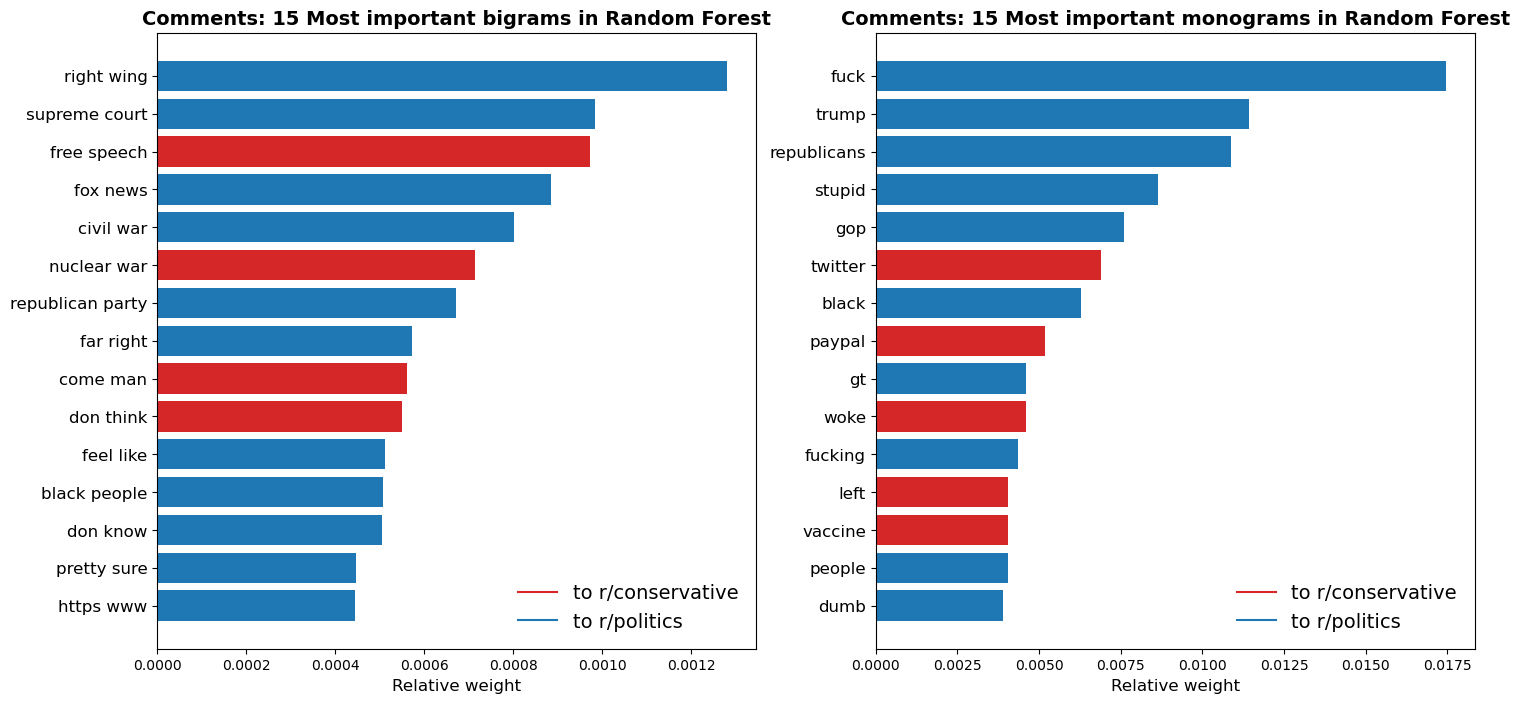

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8))

make_barplot(ax2, 15, hi_mono_imp, hi_mono_names, dir_list_mono)
make_barplot(ax1, 15, hi_bi_imp, hi_bi_names, dir_list_bi)

ax1.set_title('Comments: 15 Most important bigrams in Random Forest', fontweight='bold', fontsize=14)
ax2.set_title('Comments: 15 Most important monograms in Random Forest', fontweight='bold', fontsize=14)

#dummy legend (because barplot is a single command:
labels = ['to r/conservative', 'to r/politics']
colors=['tab:red', 'tab:blue']
dummies = [ax1.plot([], [], ls='-', c=c)[0] for c in colors]        
ax1.legend(dummies, labels, frameon=False, numpoints=1, fontsize=14, loc='lower right')
ax2.legend(dummies, labels, frameon=False, numpoints=1, fontsize=14, loc='lower right')


fig.savefig('../figures/com_rf_features.png', dpi=300)

plt.show()

### 2.2) Logistic Regression Interpretation

In [38]:
lr_in_stack = stacked_model_coms.named_estimators_.m1.named_steps.lr
lr_coefs = lr_in_stack.coef_[0]
ct1_in_stack = stacked_model_coms.named_estimators_.m1.named_steps.ct
lr_feature_names = ct1_in_stack.get_feature_names_out()

In [39]:
zipped_lr = zip(lr_feature_names, lr_coefs)
sorted_lr = sorted(zipped_lr, key= lambda x: np.abs(x[1]), reverse=True)[:500]

In [40]:
sorted_lr[:20]

[('tfbg__fuck', 7.194440177262211),
 ('tfbg__stupid', 5.698732252326108),
 ('tfbg__black', 5.051412569021431),
 ('tfbg__gop', 4.206608095765812),
 ('tfbg__paypal', -4.1524147291260505),
 ('tfbg__republicans', 4.125536176601962),
 ('tfbg__gay', 3.8597314411874954),
 ('tfbg__dumb', 3.700168317576061),
 ('tfbg__leftists', -3.636207733479781),
 ('tfbg__kill', 3.4616101490439424),
 ('tfbg__vaccine', -3.36456406378344),
 ('tfbg__twitter', -3.3407382902521023),
 ('tfbg__woke', -3.2837823947997102),
 ('tfbg__idiots', 2.957987746119257),
 ('tfbg__trump', 2.9561103379044558),
 ('tfbg__shoot', 2.7660691937216044),
 ('tfbg__leftist', -2.6973477837651396),
 ('tfbg__left', -2.612182281524367),
 ('tfbg__idiot', 2.608603575072556),
 ('tfbg__fox', 2.5925701861000223)]

In [41]:
hi_mono_names, hi_bi_names = [], []
hi_mono_imp, hi_bi_imp = [], []

for feature in sorted_lr:
    add_features(feature, hi_mono_names, hi_mono_imp,  hi_bi_names, hi_bi_imp)

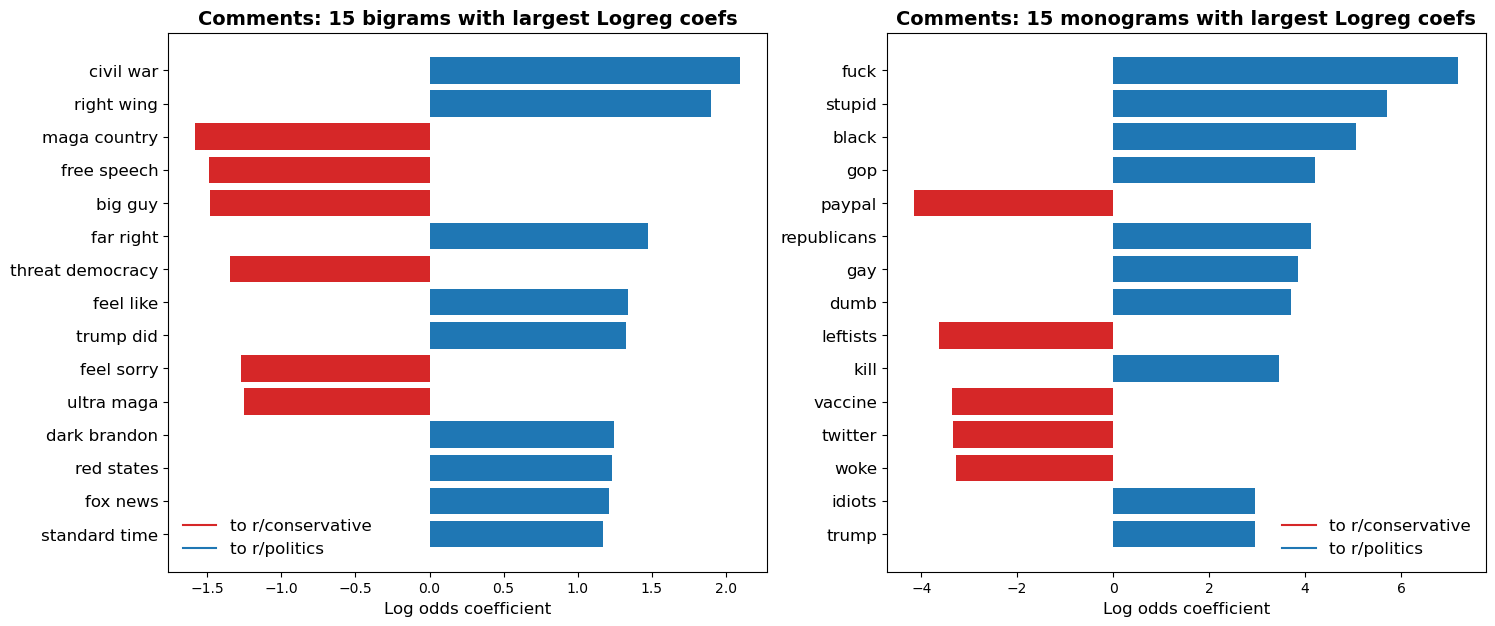

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))

make_barplot_lr(ax2, 15, hi_mono_imp, hi_mono_names)
make_barplot_lr(ax1, 15, hi_bi_imp, hi_bi_names)

ax1.set_title('Comments: 15 bigrams with largest Logreg coefs', fontweight='bold', fontsize=14)
ax2.set_title('Comments: 15 monograms with largest Logreg coefs', fontweight='bold', fontsize=14)

#dummy legend (because barplot is a single command:
labels = ['to r/conservative', 'to r/politics']
colors=['tab:red', 'tab:blue']
dummies = [ax1.plot([], [], ls='-', c=c)[0] for c in colors]        
ax1.legend(dummies, labels, frameon=False, numpoints=1, fontsize=12, loc='lower left')
ax2.legend(dummies, labels, frameon=False, numpoints=1, fontsize=12, loc='lower right')


fig.savefig('../figures/com_lr_features.png', dpi=300)

plt.show()

### 2.3) Naive Bayes Interpretation

In [43]:
nb_in_stack = stacked_model_coms.named_estimators_.m3.named_steps.nb
nb_logprobs = nb_in_stack.feature_log_prob_
nb_relprobs = np.exp(nb_logprobs[1])/np.exp(nb_logprobs[0])
ct3_in_stack = stacked_model_coms.named_estimators_.m3.named_steps.ct
nb_feature_names = ct3_in_stack.get_feature_names_out()

In [44]:
zipped_nbf = zip(nb_feature_names, nb_relprobs)
sorted_nbf = sorted(zipped_nbf, key= lambda x: x[1], reverse=True)

sorted_nbf[:20]

[('tfbg__fuck', 55.55405982728428),
 ('tfbg__stupid', 34.91181154046277),
 ('tfbg__black', 29.08517105605839),
 ('tfbg__dumb', 18.674172849199763),
 ('tfbg__gay', 18.164836910593635),
 ('tfbg__kill', 15.929714678132157),
 ('tfbg__idiots', 15.856670243789315),
 ('tfbg__shoot', 12.835862591795655),
 ('tfbg__idiot', 12.355145158097114),
 ('tfbg__moron', 10.720278818685056),
 ('tfbg__gerrymandering', 9.313320759157621),
 ('tfbg__civil war', 9.1883409767409),
 ('tfbg__coup', 8.479358606819092),
 ('tfbg__black people', 7.539155248038488),
 ('tfbg__burn', 7.282251682252609),
 ('tfbg__ss', 7.196198256097137),
 ('tfbg__roger', 6.4762589076524),
 ('tfbg__mtg', 6.33043971787534),
 ('tfbg__dumbass', 6.236308692532192),
 ('tfbg__gqp', 6.189542012313564)]

In [45]:
hi_mono_names_p, hi_bi_names_p = [], []
hi_mono_imp_p, hi_bi_imp_p = [], []

hi_mono_names_c, hi_bi_names_c = [], []
hi_mono_imp_c, hi_bi_imp_c = [], []

for i in range(200):
    feature_p = sorted_nbf[i]
    feature_c = sorted_nbf[-(i+1)]
    
    add_features(feature_p, hi_mono_names_p, hi_mono_imp_p,  hi_bi_names_p, hi_bi_imp_p)
    add_features(feature_c, hi_mono_names_c, hi_mono_imp_c,  hi_bi_names_c, hi_bi_imp_c, inv=True)

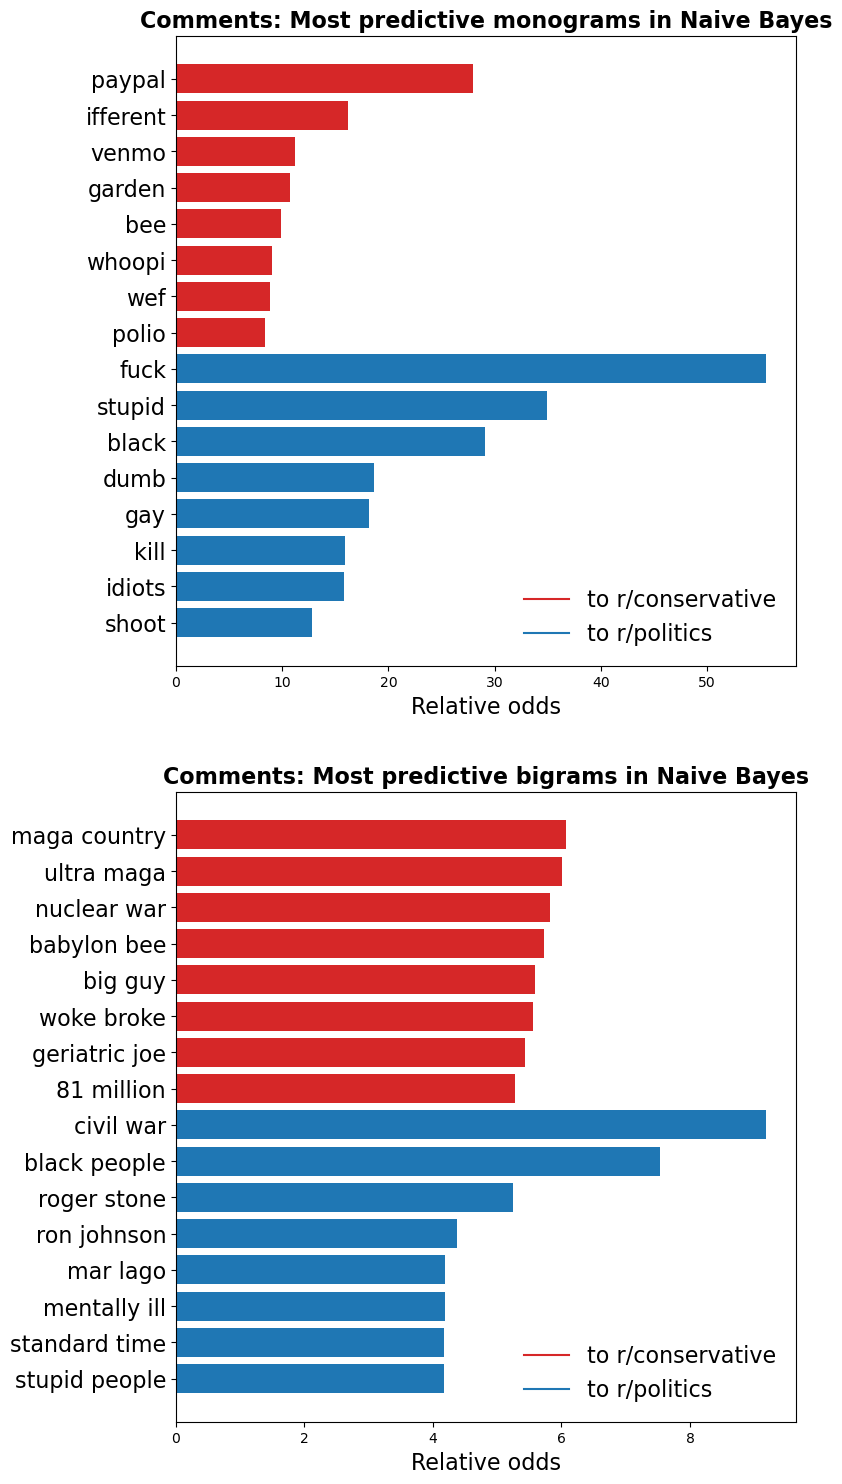

In [68]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 18))

make_barplot_nb(ax1, 8, hi_mono_imp_c, hi_mono_imp_p, hi_mono_names_c, hi_mono_names_p)
make_barplot_nb(ax2, 8, hi_bi_imp_c, hi_bi_imp_p, hi_bi_names_c, hi_bi_names_p)

ax2.set_title('Comments: Most predictive bigrams in Naive Bayes', fontweight='bold', fontsize=16)
ax1.set_title('Comments: Most predictive monograms in Naive Bayes', fontweight='bold', fontsize=16)

#dummy legend (because barplot is a single command:
labels = ['to r/conservative', 'to r/politics']
colors=['tab:red', 'tab:blue']
dummies = [ax1.plot([], [], ls='-', c=c)[0] for c in colors]        
ax1.legend(dummies, labels, frameon=False, numpoints=1, fontsize=16, loc='lower right')
ax2.legend(dummies, labels, frameon=False, numpoints=1, fontsize=16, loc='lower right')

fig.savefig('../figures/com_nb_features.png', dpi=300)
plt.show()

### 2.4) Misclassified Comments

Given that the overall classification rate of the model wasn't very good - is there anything we can learn from which comments were missclassified?

In [47]:
preds_test = stacked_model_coms.predict(X_test)

In [48]:
c_il = np.where(preds_test == y_test)
mc_il = np.where(preds_test != y_test)

c_idx = y_test.iloc[c_il].index
mc_idx = y_test.iloc[mc_il].index

com_class = com_df.loc[c_idx,:]
com_mclass = com_df.loc[mc_idx,:]

In [49]:
com_class.head()

,parent_id,author,created_utc,body,score,subreddit,word_length,freq_poster,sent_label,sent_score
id,,,,,,,,,,
irls7pt,4.084905e+10,ibisum,1665296164,The rhetoric:\n\nhttps://www.rand.org/pubs/res...,1,1,2,0,LABEL_1,0.8351
it1ecyi,4.093794e+10,brain_overclocked,1666246078,Indeed. This WaPo article took me all of five ...,1,1,26,1,LABEL_0,0.6552
iu33jdl,4.099516e+10,HillbillySwank,1666932875,"Funny, when someone wins the PA lotto, they kn...",1,0,32,0,LABEL_1,0.5091
it63em9,4.094515e+10,strangetrip666,1666328774,"Yeah, I can agree with that. When you get comf...",1,1,65,0,LABEL_0,0.9328
iv8u72i,NaN,LukariBRo,1667708586,But will the author still be working at CNN in...,1,0,12,0,LABEL_1,0.7615


In [50]:
com_class.shape, com_mclass.shape

((7851, 10), (4142, 10))

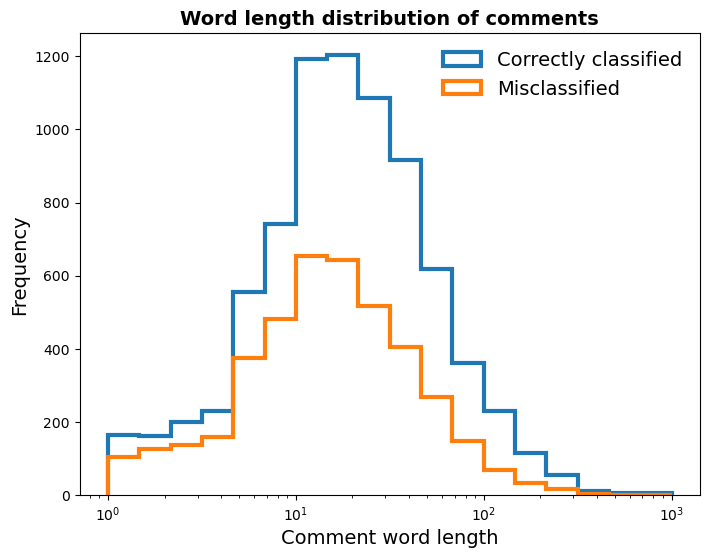

In [51]:
fig, ax = plt.subplots(figsize=(8,6))

logbins = np.logspace(0, 3, 19)
ax.hist(com_class['word_length'], histtype='step', linewidth=3, bins=logbins, label='Correctly classified')
ax.hist(com_mclass['word_length'], histtype='step', linewidth=3,  bins=logbins, label='Misclassified')

ax.set_xscale('log')
ax.legend(frameon=False, numpoints=1, fontsize=14)
ax.set_xlabel('Comment word length', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Word length distribution of comments', fontsize=14, fontweight='bold')
plt.show()


In [52]:
display(com_class[['word_length']].describe().T)
display(com_mclass[['word_length']].describe().T)


,count,mean,std,min,25%,50%,75%,max
word_length,7851.0,31.575468,48.90709,1.0,9.0,18.0,36.0,1608.0


,count,mean,std,min,25%,50%,75%,max
word_length,4142.0,24.729599,32.786147,1.0,7.0,15.0,29.0,468.0


In [53]:
com_lens = np.logspace(0.5, 2.5, 19)

cl_up = []
for com_len in com_lens:
    long_coms_c = com_class[com_class['word_length'] > com_len].shape[0]
    long_coms_mc = com_mclass[com_mclass['word_length'] > com_len].shape[0]
    len_acc = long_coms_c/(long_coms_c + long_coms_mc)
    cl_up.append(len_acc)

cl_down =[]
for com_len in com_lens:
    long_coms_c = com_class[com_class['word_length'] < com_len].shape[0]
    long_coms_mc = com_mclass[com_mclass['word_length'] < com_len].shape[0]
    len_acc = long_coms_c/(long_coms_c + long_coms_mc)
    cl_down.append(len_acc)

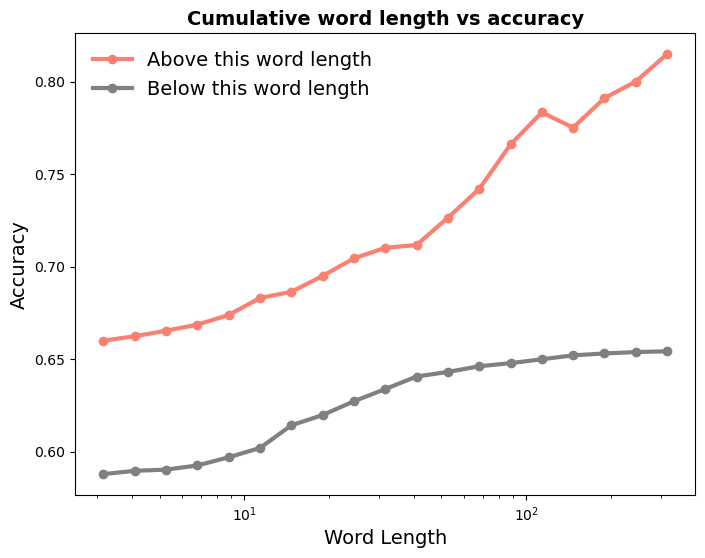

In [54]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(com_lens, cl_up, color='salmon', marker='o', linewidth=3, label='Above this word length')
ax.plot(com_lens, cl_down, color='grey',  marker='o', linewidth=3, label='Below this word length')

ax.set_xscale('log')
ax.set_xlabel('Word Length', fontsize=14)
ax.legend(numpoints=1, frameon=False, fontsize=14)
ax.set_title('Cumulative word length vs accuracy',  fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=14)
fig.savefig('../figures/wl_acc.png', dpi=300)
plt.show()

Misclassified comments are shorter on average, which makes sense - there is less for the model to grab onto. But still, it takes quite a while for the effect to be significant. Even in comments with 100 words, the accuracy is still 'only' 77% - still worse than the Title model.

Can we say something about the vectorized content of the misclassified rows? Let's use the ColumnTransformer in the random forest pipeline

In [55]:
Xtest_transform = ct2_in_stack.transform(X_test)
Xtest_mc = Xtest_transform[mc_il[0], :]
Xtest_c = Xtest_transform[c_il[0], :]

In [56]:
summed_X_mc = np.sum(Xtest_mc, axis=1)
summed_X_c = np.sum(Xtest_c, axis=1)
np.mean(summed_X_mc), np.mean(summed_X_c)

(3.725515490416165, 4.291566503761262)

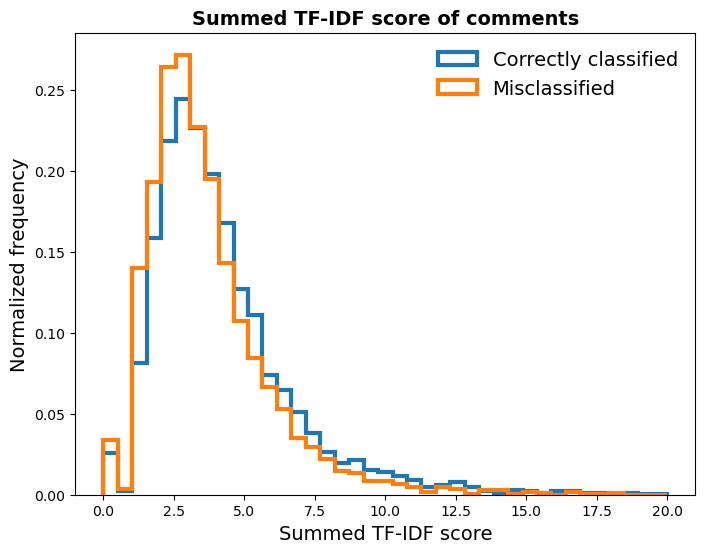

In [57]:
fig, ax = plt.subplots(figsize=(8,6))

linbins = np.linspace(0, 20, 40)
ax.hist(summed_X_c, histtype='step', linewidth=3, bins=linbins, density=True, label='Correctly classified')
ax.hist(summed_X_mc, histtype='step', linewidth=3,  bins=linbins, density=True, label='Misclassified')

ax.legend(frameon=False, numpoints=1, fontsize=14)
ax.set_xlabel('Summed TF-IDF score', fontsize=14)
ax.set_ylabel('Normalized frequency',fontsize=14)
ax.set_title('Summed TF-IDF score of comments', fontsize=14, fontweight='bold')
plt.show()

These distributions are again pretty similar, although on average the summed value of the Tfidf words is a little higher for correctly classified comments. Which makes sense, it means there is more chance for the model to grab on to some term that might be predictive.

What about the predicted probabilities, using predict_proba? Is it possible that the model is more unsure of misclassified comments (eg. the distribution is closer to 0.5), than for correctly classified comments?

In [58]:
X_c = com_class[['body', 'score', 'word_length', 'freq_poster', 'sent_label']]
X_mc = com_mclass[['body', 'score', 'word_length', 'freq_poster', 'sent_label']]

probs_c = stacked_model_coms.predict_proba(X_c)
probs_mc = stacked_model_coms.predict_proba(X_mc)

Let's get the baseline accuracy again:

In [59]:
y.value_counts(normalize=True)

1    0.539368
0    0.460632
Name: subreddit, dtype: float64

In [60]:
base_conservative = y.value_counts(normalize=True)[0]

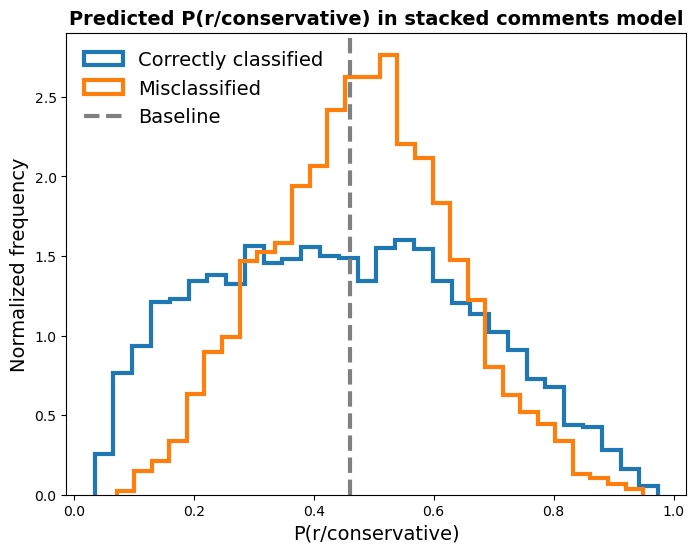

In [61]:
fig, ax = plt.subplots(figsize=(8,6))

ax.hist(probs_c[:,0], histtype='step', linewidth=3, bins=30, density=True, label='Correctly classified')
ax.hist(probs_mc[:,0], histtype='step', linewidth=3,  bins=30, density=True, label='Misclassified')

ax.axvline(base_conservative, color='grey', linewidth=3, linestyle='dashed', label='Baseline')
ax.legend(frameon=False, numpoints=1, fontsize=14, loc='upper left')
ax.set_xlabel('P(r/conservative)', fontsize=14)
ax.set_ylabel('Normalized frequency', fontsize=14)
ax.set_title('Predicted P(r/conservative) in stacked comments model', fontsize=14, fontweight='bold')
fig.savefig('../figures/proba_classes.png', dpi=300)
plt.show()

This was probably expected, but it's still a good thing to see: for the correctly classified comments, the model is more often more certain in its prediction. The misclassified comments are those where the predicted probability is close to 0.5. Out of all the misclassified comments, how many have a predicted probability between 0.4 and 0.6?

In [62]:
print(f'Total number of misclassified comments {probs_mc.shape[0]}')
mc_close = sum([1 for x in probs_mc[:,0] if x > 0.40 and x < 0.60])
print(f'Total number of misclassified comments with 0.4 < proba < 0.6: {mc_close}')

Total number of misclassified comments 4142
Total number of misclassified comments with 0.4 < proba < 0.6: 1986


So roughly half of the misclassified comments have P(r/conservative) between 0.4 and 0.6, which means the model isn't very sure of these predictions to begin with. 

One other perspective on the above plot is in terms of bias and variance. When the model is quite sure of a prediction, yet that prediction turns out to be wrong, it probably means that it erroneously placed a lot of confidence in certain model features that it encountered in that comment (high variance). For the predictions close to 0.5, it is more likely to mean that nothing encountered in the comment shifted the probability very far away from the baseline accuracy (high bias). In the comments model, we clearly have both to some extent, which also shows up in the accuracy scores: the accuracy score on the training data is 20% higher than on the testing data, and the overall accuracy isn't all that high.

Together with the dependence of accuracy on word length, it's clear that the reason why the accuracy score gets stuck at around 65% is due to some comments simply not containing enough information. There aren't enough 'significant' words that can convince the model one way or the other, and so the predicted probability stays fairly close to the baseline model.

### 2.5) Comments Model insights: Summary

In the section aove, I've tried to interpret the output of the base estimators contained in my stacked classifier for the reddit comments. For each of the base models in the stacking classifier, I've created visualizations of the monograms and bigrams that appear to be most predictive of which subreddit the comment comes from.

In terms of the model evaluation, the model classifies comments with the follow accuracy:

In [63]:
train_acc = stacked_model_coms.score(X_train, y_train)
test_acc = stacked_model_coms.score(X_test, y_test)

In [64]:
print(f'The accuracy on the training data is {round(train_acc, 5)}')
print(f'The accuracy on the test data is {round(test_acc, 5)}')

The accuracy on the training data is 0.85266
The accuracy on the test data is 0.65463


Like with the titles model, the model is overfit significantly - but I was unable to find a model that is less overfit that still does better on the testing data. The overall accuracy on the testing data ifs 65.4%.

I've looked at which comments typically get misclassified, and there is a clear correlation visible between overall word length and accuracy. This makes sense, as short comments are less likely to have a word in them that helps the model clearly distinguish between the two subreddits. Misclassified comments more often are in the predicted probability range of 40-60%, which implies that the words in the comment do not move the needle all that much from the baseline model - the model is therefore less sure about these comments.

Ultimately, the somewhat low accuracy score for this model is disappointing but perhaps not that surprising. There is little data to go on with some of the comments, and given the fact that the two subreddits chosen for this project are both political, it will typically take more than just a few words for the classifier to work well.

# 3) Overall Conclusions

Using Pushshift API, I collected data from two different subreddits, r/politics and r/conservative, from the month leading up to the 2022 midterms (October 2022). I tested out different classification models in order to classify 1) the post titles, and 2) the comments of either subreddit. After data cleaning, I was left with about 19,000 post titles (53/47 split for r/conservative - r/politics, respectively), and 48,000 comments (47/53 split).  In order to model the language, we used a 'bag of words' approach with a TF-IDF (Term Frequency - Inverse Document Frequency) vectorizer.

For the titles model, other than the title I included two additional pieces of information: the number of comments on each post, and the domain name that the post linked to. The final model that I used consists of a Stacking Classifier, using Logistic Regression, Random Forest, and Multinomial Naive Bayes as the base estimators. and a Logistic Regression as the final estimator. The final accuracy on the testing data is <b>88.1%</b>. Analysis of the feature importances indicates that the domain names are highly predictive and help improve the accuracy score a lot. This makes a lot of sense given the fact that the US political media system is highly polarized, and certain websites are only read by conservatives while others are highly avoided by conservatives, and vice versa.

For the comments model, I included several other pieces of information: the score of the comment, the word length, whether the commenter is a frequent poster or not, and the sentiment of the comment (Negative/neutral/positive, using sentiment analysis with the roBERTa model). The best-performing model was again a Stacking classifier with the same estimator components as for the titles model. The final accuracy on the testing data is <b>65.4%</b>. Unlike with the titles model, it appears that none of the additional non-language features I added improve the accuracy by very much. One of the main reason for misclassification appears to be the fact that many comments are just too short for the model to be able to classify them with much certainty.

The base models that make up the Stacking Classifier allow us to look into which features add predictive power to the model, which means we can look at the language that is used and the degree to which this determines whether the post or comment comes from either subreddit. Although a full analysis of language use is beyond the scope of this project, using the visualizations in this notebook we can point to some directions that might warrant further exploration or analysis: 

1) <b>Abortion</b>: discussions about this topic have greatly flared up since the Dobbs v Jackson decision by the Supreme Court in June 2022. We can see this discussion show up in different ways in the two subreddits: the phrase 'pro life' appears to be highly predictive of r/conservative, which makes sense as this moniker is often used by anti-abortionists to describe themselves. On the r/politics side, the terms 'Supreme Court' and 'abortion' show up as important features

2) <b>Presidents</b>: it appears that 'Biden' is much more mentioned on the conservative side (see also 'geriatric joe') while Trump (and related terms like 'mar lago') is more often mentioned on r/politics 

3) <b>The pandemic</b>: it appears that on r/politics, COVID and the pandemic may not have been as important in the discourse as on r/conservative. On r/conservative, we can see terms like 'covid' and 'vaccine' as important features, but equivalents are not directly obvious on r/politics

4) <b>The other side of the political aisle</b>: both side use certain terms to describe the other side. On r/conservative, we see highly predictive features such as 'left', 'leftists', while r/politics uses terms like 'right wing' and 'far right'.

Ultimately, we were quite a bit more succesful in classifying posts compared to comments. This is largely due to the domain feature that is included with the posts model. In this particular case, more comments data might help combat overfitting and avoid the model erroneously adding significance to certain words. Performance may be slightly improved by  more hyperparameter tuning of the stacking classifier as well.